## Disclaimer & Copyright

Copyright 2024 Forusone : shins777@gmail.com

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Gemini - Solve math problem, understanding mathematics logic
* This notebook explains how to use Gemini to understand images in multimodality features of Gemini.  
* This code shows how the Gemini multimodality understands mathematics problems and logic to solve the problems.
* Refer to the link for more information about the Gemini
 * ***https://cloud.google.com/vertex-ai/generative-ai/docs/learn/overview***

# Configuration
## Install aiplatform library
* Vertex AI SDK for Python
  * https://cloud.google.com/python/docs/reference/aiplatform/latest
* Vertex AI initialization : aiplatform.init(..)
  * https://cloud.google.com/python/docs/reference/aiplatform/latest#initialization

In [ ]:
%pip install --upgrade --quiet google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Markdown

## Authentication to access to the GCP

* Use OAuth to access the GCP environment.
 * Refer to the authentication methods in GCP : https://cloud.google.com/docs/authentication?hl=ko

In [ ]:
#  For only colab to authenticate to get an access to the GCP.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

* Mount to the google drive to access the .ipynb files in the repository.

In [ ]:
# To access contents in Google drive

if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Image source
* * The following image was downloaded from the below URL.
  * https://www.donga.com/news/Society/article/all/20090922/8812199/1
* Don't use the following image for other purpose.

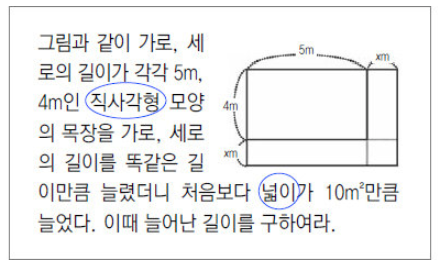

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/projects/google_gen_ai_sample/contents/images/math.png', width=400, height=300)

# Execute the example
## Set the environment on GCP Project
* Configure project information
  * Model name : LLM model name : https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models
  * Project Id : prodect id in GCP
  * Region : region name in GCP

In [ ]:
MODEL_NAME="gemini-1.5-flash"
PROJECT_ID="ai-hangsik"
REGION="asia-northeast3"

### Vertex AI initialization
Configure Vertex AI and access to the foundation model.

In [ ]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models

# Initalizate the current vertex AI execution environment.
vertexai.init(project=PROJECT_ID, location=REGION)

# Access to the generative model.
model = GenerativeModel(MODEL_NAME)

## Encoding function for multimodality

In [ ]:
import base64

def get_encoded_content(location_type, location, mime_type ):
  """
  Get the encoded content object.

  location_type :
    The type of the location. ( local or GCS )
  location :
    The file location of the content.
  mime_type :
    The mime type of the content.

  Returns:
    The encoded content object.

  """

  content_obj = None

  if location_type == "local":
    with open(location, 'rb') as f:
      raw_obj = base64.b64encode(f.read()).decode('utf-8')
      content_obj = Part.from_data(data=base64.b64decode(raw_obj), mime_type=mime_type)

  elif location_type == "GCS":
        content_obj = Part.from_uri(location, mime_type=mime_type)
  else:
    raise ValueError("Invalid location type.")

  return content_obj

## Get responses from Gemini

In [ ]:
def generate(content_obj, query:str):
    """
    Generate a response from the model.

    content_obj :
      encoded object being analyzed in the process
    query :
      query to be sent to the model

    Returns:
      The generated response.

    """

    # Set model parameter : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts#set_model_parameters
    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    # Configure satey setting : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes
    # Refer to the link to remove : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes#how_to_remove_automated_response_blocking_for_select_safety_attributes
    safety_settings = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }

    responses = model.generate_content(
        [content_obj, query],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )

    return responses.text

## Run the example

In [ ]:

from time import perf_counter

t1_start = perf_counter()

# When using local storage for the file location.
location_type = "local"
mime_type = "image/png"

repository_root = "/content/drive/MyDrive/projects"
file_path = "/google_gen_ai_sample/contents/images/math.png"
location = repository_root + file_path

content_obj = get_encoded_content(location_type, location, mime_type )

prompt = """
You are a math tutor here to help students with their math homework.
Your objective is to help students with math problems without directly giving them the answer.
1. Explain about the question written on the image
2. Understand what the problem is asking.
3. Understand where the student is stuck.
4. Give a hint for the next step of the problem.
5. Explain the answer in Korean

"""

outcome = generate(content_obj, prompt)

t1_end  = perf_counter()
print(f"Time : {t1_end - t1_start} seconds\n\n")

display(Markdown(outcome))


# When using Google Cloud Storage for the location type.

# location_type = "GCS"
# mime_type = "image/jpeg"
# repository_root = "gs://bucket_name"
# file_path = "/math.jpeg"
# location = repository_root + file_path

Time : 4.788287651000019 seconds




이 문제는 직사각형 모양의 목장을 가로와 세로의 길이를 똑같이 늘렸을 때 넓이가 10제곱미터 늘어난 상황을 주고 늘어난 길이를 구하라고 하는 문제입니다.

어떤 부분이 어려운가요? 어디까지 계산해 보셨나요?

힌트를 드릴게요. 

**처음 목장의 넓이를 구해보세요. 그리고 늘어난 후 목장의 넓이를 구해보세요. 늘어난 넓이가 10제곱미터라는 것을 이용하면 늘어난 길이를 구할 수 있을 거예요.**

풀이를 설명해 드릴게요.

처음 목장의 넓이는 가로 5m * 세로 4m = 20제곱미터입니다. 

늘어난 후 목장의 넓이는 20제곱미터 + 10제곱미터 = 30제곱미터입니다.

늘어난 후 목장의 넓이를 (5 + x) * (4 + x)로 나타낼 수 있습니다. 여기서 x는 늘어난 길이입니다.

(5 + x) * (4 + x) = 30 이라는 식을 풀면 x 값을 구할 수 있습니다.

이 식을 풀면 x² + 9x - 10 = 0 이 됩니다. 인수분해를 하면 (x+10)(x-1) = 0 이 되고, x = -10, x = 1 이라는 해를 얻습니다. 길이는 음수가 될 수 없으므로 늘어난 길이는 1m 입니다. 

따라서 답은 1m입니다.